# Transitions
In this section, we calculate
1) overall probability a specific transition between sentences will be made
2) the conditional repsonse probability two sentences are both remembered in the same session
3) the conditional repsonse probability of transitioning to one sentnece, having just remembered a another sentence

**Motivation:** 
* This allows us to visualize patterns in how people remembering information from a text, and collect evidence for chunking (a form of retrieval induced-faciliation) and competition (retrieval induced forgetting).

##### **1) Probability of Transitions**

Let's compute the regular probabilities that specific transitions will occur for each given passage.

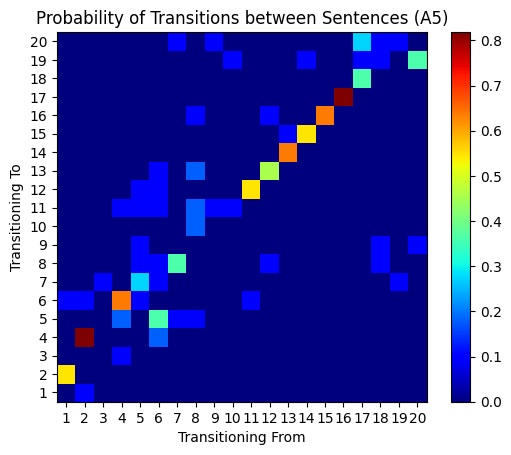

In [2]:
# (0) Load in recall data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("data\psifr_al1_ml1_sl.csv")
df = df.query("modality == 'EEG' or modality == 'MRI'")          # immediate free recall

# (1) Get Probabilties
passages = ["A5"]#["A1","A2", "A3", "A4", "A5"]
for pas_id in passages:
    pas_df = df.query(f"story_list == '{pas_id[0]}' and passage == {int(pas_id[1])} ")

    transitions_made = []       # Records transitions actually made
    transitions_possible = []   # Record  transitions could have been made

    groupby_columns = ["subject", "list"]
    for trial_index, trial in enumerate(pas_df.groupby(groupby_columns)):
        trial = trial[1]
        recall_sequence = trial.query("recall").sort_values("output")["input"].to_list()

        trans_made = [(recall_sequence[i], recall_sequence[i+1]) for i in range(len(recall_sequence) - 1)]
        transitions_made += trans_made

    num_trials = trial_index

    num_sentences = len(trial)
    transition_probabilities = np.zeros(shape=(num_sentences, num_sentences))

    for i in range(num_sentences):
        for j in range(num_sentences):
            N = transitions_made.count((i+1,j+1))     # number of times a transition was made
            transition_probabilities[j,i] = N / num_trials


    # (2) Plot Probabilities
    im = plt.imshow(transition_probabilities, cmap='jet', interpolation='none', origin='lower')
    plt.title(f"Probability of Transitions between Sentences ({pas_id})")
    plt.xlabel("Transitioning From")
    plt.ylabel("Transitioning To")
    plt.xticks(ticks=range(0,num_sentences), labels=range(1,num_sentences + 1))
    plt.yticks(ticks=range(0,num_sentences), labels=range(1,num_sentences + 1))
    plt.colorbar(im)
    plt.show()

    break



Here we see that participants chaining/chunking some specific sentences together (*chunking here means >50% participants make a sequence transitions between 3 consecutive sentences*):

| Passage | Sentences | Theme | Reason for Grouping (Guess) |
| - | - | - | - |
| A1 - Abscesses | 1-3 | Introduction / small abscesses | shared concept |
| A2 - Burns | 17-20 |  Rule of nines | shared syntax |
| A3 - Eye Injuries  | 1-3 | Introduction / 1st way of treating | logical structure of passage (compare and contrast) | 
| A3 - Eye Injuries  | 6-9 | 2nd  way of treating | logical structure of passage (compare and contrast)| 
| A5 - Soft Tissue | 2,4,6 | Introduction, abrasions, and contusions | logical structure of passage (compare and contrast) | 
| A5 - Soft Tissue | 11-17 |  Treatment |  shared subject |


It looks some sentences are chunked together, because most skilled readers they recognize the way information is organized (compare and contrast) as use that as a retrieval cue, or because all the sentences have the share the same structure or subject.

`Note:` The CMR / TCM cannot explain why there are specific transitions that nearly all participant make.

##### **2) CRP of  sentence i being recalled given sentence j was**

Let's compute the CRP of sentence `i` being in a recall sequence given sentence `j` is recall sequence.

##### **3) CRP of transitioning to sentence j given just recalled sentence i**

* These plots are hard to interpret because we can't see whether a high CRP of making a specific transition is caused by chunking two sentences together, or is the result of the condition rarely being satisfied (sentence `i` hardly being remembered).

In [ ]:
# (0) Load in recall data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv("data\psifr_al1_ml1_sl.csv")
df = df.query("modality == 'EEG' or modality == 'MRI'")          # immediate free recall

# (1) Get CRPS
passages = ["A1","A2", "A3", "A4", "A5"]
for pas_id in passages:
    pas_df = df.query(f"story_list == '{pas_id[0]}' and passage == {int(pas_id[1])} ")

    transitions_made = []       # Records transitions actually made
    transitions_possible = []   # Record  transitions could have been made

    groupby_columns = ["subject", "list"]
    for trial_index, trial in enumerate(pas_df.groupby(groupby_columns)):
        trial = trial[1]
        recall_sequence = trial.query("recall").sort_values("output")["input"].to_list()

        trans_made = [(recall_sequence[i], recall_sequence[i+1]) for i in range(len(recall_sequence) - 1)]
        transitions_made += trans_made

        sentences_remaining = [i for i in range(1, len(trial) + 1)]
        for sent_recalled in recall_sequence[:-1]:                   # exclude the last sentence (as no more transitions are made)
            sentences_remaining.remove(sent_recalled)
            transitions_pos = [(sent_recalled, sent_remain) for sent_remain in sentences_remaining]
            transitions_possible += transitions_pos

    num_sentences = len(trial)
    crps = np.zeros(shape=(num_sentences, num_sentences))
    for i in range(num_sentences):
        for j in range(num_sentences):
            N = transitions_made.count((i+1,j+1))      # number of times transition from sentence i->j was made
            D = transitions_possible.count((i+1,j+1))
            crps[j,i] = N / D if D != 0 else 0         # crp[j,i] = CRP of transitioning to sentene j have just recalled i


    # (2) Plot CRPs
    im = plt.imshow(crps, cmap='jet', interpolation='none', origin='lower')
    plt.title(f"CRPs of Specific Transitions between Sentences ({pas_id})")
    plt.xlabel("Transitioning From")
    plt.ylabel("Transitioning To")
    plt.xticks(ticks=range(0,num_sentences), labels=range(1,num_sentences + 1))
    plt.yticks(ticks=range(0,num_sentences), labels=range(1,num_sentences + 1))
    plt.colorbar(im)
    plt.show()

    break

# Lag CRP
 In this section, we will calculate the conditional repsonse probabilities of remembering a chunk of information (idea unit) from nearby sentences, having just recalled information from a particular sentence in a passage.


* Lag of 0 = next remember an idea from the same sentence in the passage. 
* Lag of +1, -1 = next remember an idea expressed in a sentence before or ahead in the passage.


**Motivation:** 
* We want to see whether people remember information on the level of sentences. If they do, a sentence lag of 0 should have a high (`>90%`) conditional response probability

## (0) Load in Data

In [1]:
# | code-summary: import dependencies, load raw data
import os
import glob
import pandas as pd
import numpy as np
from psifr import fr

data_path_AL1 = "C:/Users/elija/Vanderbilt/Aboud, Katherine - Team/Projects/AL1_NIH_DP5/AL1_Data_Backup/AL1_scanned/*/audio/*_free_recall*.xlsx"
data_paths_AL1 = glob.glob(data_path_AL1)

datasets_AL1 = [
    pd.read_excel(data_path, [0], engine="openpyxl")[0] for data_path in data_paths_AL1
]

data_path_ML1 = "C:/Users/elija/Vanderbilt/Aboud, Katherine - Team/Projects/ML1_xTech_tACS/ML1_Data_Backup/ML1_scanned/*/*_free_recall*.xlsx"
data_paths_ML1 = glob.glob(data_path_ML1)
datasets_ML1 = [
    pd.read_excel(data_path, [0], engine="openpyxl")[0] for data_path in data_paths_ML1
]

datasets = datasets_AL1 + datasets_ML1 
#| code-summary: track study and recall events in a long table, pairing with trial-level variables

results = []

data_columns = [
    "subject",
    "list",
    "trial_type",
    "position",
    "item",
    "item_string",
    "subject_id",
    "story_list",
    "passage",
    "visit",
    "session",
    "modality",
    "list_length",
    "recTex"
]

for subject_index, data in enumerate(datasets):
    if "Passage index" in data.columns:
        groupby_columns = ["Passage index", "Visit", "Session", "List"]
    else:
        groupby_columns = ["Passage", "Visit", "Session", "List"]

    for trial_index, trial in enumerate(data.groupby(groupby_columns)):
        # sequence of idea units encoded during study
                # trial[0] is a tuple specifying group information (Passage, Visit, Session)
                # trial[1] is dataframe for that group

        # identify trial-level variables
        passage_index = int(trial[0][0])
        visit = int(trial[0][1])
        session = int(trial[0][2])
        subject_id = trial[1][data.columns[0]].values[0]
        story_list = trial[1]["List"].values[0]
        modality = trial[1]["Modality"].values[0]

        # sequence of idea units encoded during study
        source_units = trial[1]["origText"].values

        # build study event list based on extracted story information
        for unit_index, unit in enumerate(source_units):
            results.append(
                [
                    subject_index,
                    trial_index,
                    "study",
                    unit_index + 1,
                    unit_index,
                    unit,
                    subject_id,
                    story_list,
                    passage_index,
                    visit,
                    session,
                    modality,
                    len(source_units),
                    "NA"
                ]
            )

        # clean up column containing positions of recalled idea units
        clean_recall_positions = trial[1]["posRec"].values
        for i in range(len(clean_recall_positions)):
            if type(clean_recall_positions[i]) == str:
                clean_recall_positions[i] = clean_recall_positions[i].strip()
                if clean_recall_positions[i] == "NA":
                    clean_recall_positions[i] = np.nan
                else:
                    raise ValueError(
                        "Unexpected value in posRec column: {}".format(
                            clean_recall_positions[i]
                        )
                    )
        trial[1]["posRec"] = clean_recall_positions
        trial = trial[1].sort_values(by="posRec")

        ## (ADDITION of Recall Text)
        try:
            recTex = trial["recTex"].to_list()
        except KeyError:
            print(subject_id, "does not have 'recTex' column.")
            assert(False)
        # build recall event list based on extracted story information
        recall_positions = trial["posRec"].values
        serial_positions = trial["serialPos"].values
        posRec = 1
        for i in range(len(recall_positions)):
            if np.isnan(recall_positions[i]):
                break

            # move to next entry if value can't be cast as integer
            try:
                serialPos = int(serial_positions[i]) - 1
            except ValueError:
                continue

            results.append(
                [
                    subject_index,
                    trial_index,
                    "recall",
                    posRec,
                    serialPos,
                    source_units[serialPos],
                    subject_id,
                    story_list,
                    passage_index,
                    visit,
                    session,
                    modality,
                    len(source_units),
                    recTex[posRec-1]
                ]
            )

            posRec += 1

df = pd.DataFrame(results,columns=data_columns)

## (1) Calculate CRP 

In [3]:
%%capture
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

groupby_columns = ["subject", "list"]

# Lists record each transition that was actually or could possibly be made
def sentence_crp(df):
    """
    Perform a sentence CRP analysis on a free recall of passages
    
    Parameters:
        df:
            Free recall dataframe (in merged psifr format)
    
    Returns:
        crp_lst:
            List of CRP for each sentence transition"""
    possible_transitions = []
    actual_transitions = [] 

    for trial_index, trial in enumerate(df.groupby(groupby_columns)):
        trial = trial[1]

        # (1) Assign each idea unit a sentence_id
        study_df = trial.query("trial_type == 'study'")
        n = study_df.copy()
        recall_df = trial.query("trial_type == 'recall'")
        sentence_id = []
        sentence_counter = 1
        sentence_dict = {}
        for idea_unit in study_df["item_string"].to_list():
            sentence_dict[idea_unit] = sentence_counter     # Add sentence, sentence count pair dictionary
            sentence_id.append(sentence_counter)            # Add sentence_id list

            if idea_unit.strip()[-1] == '.':    # If the idea unit ends a sentence, then increase counter
                sentence_counter += 1
        
        study_df["sentence_id"] = sentence_id

        if (sentence_counter-1) != 20:      # Sanity Check
            print(sentence_counter)
            assert(False)

        sentence_id = [sentence_dict[idea_unit] for idea_unit in recall_df["item_string"].to_list()]
        recall_df["sentence_id"] = sentence_id
        

        ## (2) Tally up transtions 
        # (2.1) Numerator =  # of  times a transition was actually made
        recall_seq = recall_df["sentence_id"].tolist()
        if len(recall_seq) > 1: # Transitions were made
            act_transitions = [recall_seq[i] - recall_seq[i-1] for i in range(1,len(recall_seq))]
            actual_transitions += act_transitions

        ## (2.2) Denominator =  # of times a transition was possible
        for item, current_sent in zip(recall_df["item"], recall_df["sentence_id"]):

            if item == recall_df["item"].to_list()[-1]:   # If we are at end of recall_seq, no more transitions
                break

            else:
                #  Remove just-recalled item from the study_df (or else 0 is always going to be a possible transition)
                study_df = study_df[study_df["item"] != item]
                pos_trans = [not_rec_sent - current_sent for not_rec_sent in study_df["sentence_id"].unique().tolist()]
                possible_transitions += pos_trans


    # (3) Caluclate  CRPs

    crp_lst = []
    for i in range(-19, 19):
        numerator = actual_transitions.count(i)
        denominator = possible_transitions.count(i)
        if numerator == 0 or denominator == 0: # transition was never possible
            crp = 0
        else:
            crp = numerator / denominator
        crp_lst.append((i, crp))

    return crp_lst

# (4) Plot CRPs
def plot_sent_crp(crp_lst, max_lag):
    """Plot a sentence CRP curve.
    Parameters:
        crp_lst (List[Tuple]): 
            List of (transition, crp) tuples
        max_lag (int):
            Largest Lag 
    """
    crp_lst = [tup for tup in crp_lst if np.abs(tup[0]) < max_lag + 1]
    x = [tup[0] for tup in crp_lst]
    y = [tup[1] for tup in crp_lst]
    plt.plot(x, y, "bo")
    plt.plot(x, y, "--")
    plt.xticks(range(-max_lag, max_lag + 1))
    plt.xlabel("Lag")
    plt.ylabel("Conditional Response Probability")
    plt.title("CRP vs Sentence Lag")

Plotting CRPs!

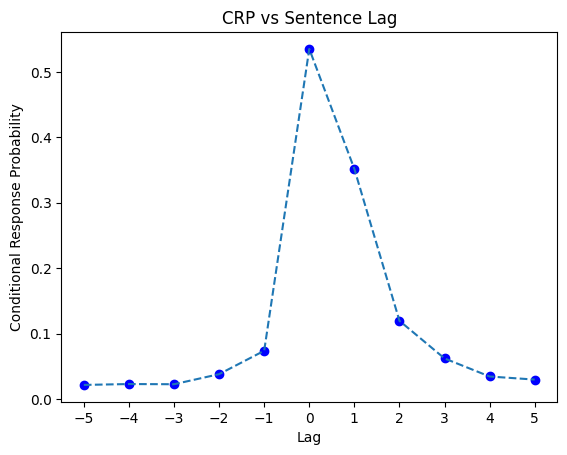

In [4]:
crps = sentence_crp(df)
plot_sent_crp(crps, 5)

In [6]:
crp_df = pd.DataFrame(crps, columns=["Lag", "CRP"]).groupby(by=["Lag"]).mean()
crp_df.query("CRP > .02").transpose()

Lag,-5,-4,-3,-2,-1,0,1,2,3,4,5
CRP,0.021552,0.022897,0.022606,0.03798,0.073734,0.534966,0.35153,0.119485,0.062,0.034428,0.029703


* There is a `>50%` probability that if a participant can remember more information from the same sentence they just recalled an 'idea unit' from, they will. This is a sign that peoply don't completely remember text on the level of sentences

* Furthermore, CRPs for forward transitions (+1, +2, +3 sentences ahead) are greater than the CRP for a backward transition (-1). This is tells us that the way people usually recreate the text is by remembering information from the first sentence that they can, and then the next sentence in the passage they can, and so on.
  * Also some sentence require infromation from previous sentence in order for it to be possibly remembered.

---

**Conclusion:** In this notebook, we found participants **don't** remember information from a text entirely on the level of sentences. 

* Taking this further, we know people also don't remember information fully on the level of 'idea units'. For example, sometimes people remember half of the key words from an idea unit

In [26]:
# Example
import pandas as pd
df = pd.read_csv("data\psifr_al1.csv")
df = df.query("item_string == 'open flame, hot liquid, chemicals, or electricity.' and recall == True")[["item_string", "recTex"]]
df.head(5)

,item_string,recTex
116,"open flame, hot liquid, chemicals, or electric...",chemical or combustion
268,"open flame, hot liquid, chemicals, or electric...","It an electrical current,"
634,"open flame, hot liquid, chemicals, or electric...","thermal, and chemical"
1066,"open flame, hot liquid, chemicals, or electric...",or flame
1454,"open flame, hot liquid, chemicals, or electric...",but they also talked about chemical burns or


* Even individual words people don't always completely remember (ex. APVU, Nasopharygeal, etc.)



In [32]:
df = pd.read_csv("data\psifr_al1.csv")
df = df.query("item_string == 'For the AVPU scale,' and recall == True")[["item_string", "recTex"]]
df.head()


,item_string,recTex
734,"For the AVPU scale,",there was another scale APVU
981,"For the AVPU scale,",the APVU method
1016,"For the AVPU scale,",or the APVU method
1271,"For the AVPU scale,",four initials that started with an A
1306,"For the AVPU scale,","the second one is four initials, starts with an A"


Perhaps there is no fundamental unit that memories of a text are completely built up out of. Then there would be reason to use  different units of text analysis to explore effects (contiguity, memorability, retrieval-induced forgetting, etc.) and see where they are most prominent.